<a href="https://colab.research.google.com/github/MartonJToth/KepszintezisLabor/blob/master/KepszintezisLabor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install ellenőrzés

In [11]:
!pip3 install torch torchvision 
!pip3 install Pillow==4.2.1
!pip install matplotlib

In [2]:
!nvcc --version
import torch
print(torch.cuda.is_available())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
True


Adatbázis letöltés

In [3]:
!wget http://cg.iit.bme.hu/~tmarton/deeplearning/DehazeImages.zip
!unzip -qq DehazeImages.zip
!rm DehazeImages.zip
!mkdir Results

--2019-04-20 18:04:11--  http://cg.iit.bme.hu/~tmarton/deeplearning/DehazeImages.zip
Resolving cg.iit.bme.hu (cg.iit.bme.hu)... 152.66.241.108
Connecting to cg.iit.bme.hu (cg.iit.bme.hu)|152.66.241.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 795080607 (758M) [application/zip]
Saving to: ‘DehazeImages.zip’

DehazeImages.zip    100%[===================>] 758.25M  12.9MB/s    in 1m 49s  

2019-04-20 18:06:01 (6.95 MB/s) - ‘DehazeImages.zip’ saved [795080607/795080607]



DataLoader

In [0]:
import os
import imageio
import numpy as np
import torch
import random
from torch.utils.data import Dataset
import PIL
from PIL import Image, ImageCms


class DehazeDataset(Dataset):

    train_input = []
    train_results = []

    validation_input = []
    validation_results = []

    trainNum = 0
    valNum = 0
    width = 0
    height = 0

    def __init__(self, path, type='training', percentage='0.8', transform=None):

        self.sampleNum = 0
        self.width = 0
        self.height = 0
        self.channels = 3
        self.type = type

        self.transform = transform

        self.srgb_profile = ImageCms.createProfile("sRGB")
        self.lab_profile = ImageCms.createProfile("LAB")

        self.rgb2lab_transform = ImageCms.buildTransformFromOpenProfiles(self.srgb_profile, self.lab_profile, "RGB", "LAB")

        if len(DehazeDataset.train_input) == 0:

            numFiles = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])

            first = True

            for i in range(numFiles // 2):

                istr = str(i)

                while len(istr) < 5:
                    istr = '0' + istr

                inputPath = os.path.join(path, 'hazy_' + istr + '.png')
                resultPath = os.path.join(path, 'normal_' + istr + '.png')

                if first:
                    first = False
                    im = imageio.imread(uri=inputPath)
                    DehazeDataset.width = im.shape[0]
                    DehazeDataset.height = im.shape[1]

                if random.random() <= percentage:

                    DehazeDataset.train_input.append(inputPath)
                    DehazeDataset.train_results.append(resultPath)

                else:

                    DehazeDataset.validation_input.append(inputPath)
                    DehazeDataset.validation_results.append(resultPath)

        self.width = DehazeDataset.width
        self.height = DehazeDataset.height

        if type == 'training':
            self.sampleNum = len(DehazeDataset.train_input)
        else:
            self.sampleNum = len(DehazeDataset.validation_input)

    def __len__(self):
        return self.sampleNum

    def __getitem__(self, idx):

        x = np.zeros((self.width, self.height, self.channels), dtype='f')
        y = np.zeros((self.width, self.height, self.channels), dtype='f')

        if self.type == 'training':

            inputImage = Image.open(DehazeDataset.train_input[idx])
            resultImage = Image.open(DehazeDataset.train_results[idx])

        else:

            inputImage = Image.open(DehazeDataset.validation_input[idx])
            resultImage = Image.open(DehazeDataset.validation_results[idx])

        inputImage = inputImage.resize((self.width, self.height), PIL.Image.ANTIALIAS)
        inputImage = inputImage.convert('RGB')
        resultImage = resultImage.resize((self.width, self.height), PIL.Image.ANTIALIAS)
        resultImage = resultImage.convert('RGB')

        inputImage = np.array(inputImage)
        inputImage = np.true_divide(inputImage, 255)
        resultImage = np.array(resultImage)
        resultImage = np.true_divide(resultImage, 255)

        x[:, :, :] = inputImage
        y[:, :, :] = resultImage

        x = np.transpose(x, (2, 1, 0))
        y = np.transpose(y, (2, 1, 0))

        sample = {'input': x, 'output': y}

        if self.transform:
            sample = self.transform(sample)

        return sample
      
      


Transform

In [0]:
class ToTensor(object):

    def __call__(self, sample):
        input, output = sample['input'], sample['output']

        return {'input': torch.from_numpy(input),
                'output': torch.from_numpy(output)}



Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModelScript(torch.jit.ScriptModule):
    def __init__(self):
        super(MyModelScript, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=7, padding=3)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, padding=1)
        self.b = 1

    @torch.jit.script_method
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        cat1 = torch.cat((x1, x2), 1)
        x3 = F.relu(self.conv3(cat1))
        cat2 = torch.cat((x2, x3),1)
        x4 = F.relu(self.conv4(cat2))
        cat3 = torch.cat((x1, x2, x3, x4),1)
        k = F.relu(self.conv5(cat3))

        output = k * x - k + 1
        return F.relu(output)


Training

In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def train(epoch, net, trainLoader, optimizer, criterion, haveCuda):

  # variables for loss
  running_loss = 0.0

  # set the network to train (for batchnorm and dropout)
  net.train()
  
  # Create progress bar
  bar = display(progress(0, len(trainLoader)), display_id=True)

  # Epoch loop
  for i, data in enumerate(trainLoader, 0):


    input, output = data['input'], data['output']

    # Convert to cuda conditionally
    if haveCuda:
        input, output = input.cuda(), output.cuda()


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    result = net(input)

    loss = criterion(result, output)
    loss.backward()
    optimizer.step()

    # compute statistics
    running_loss += loss.item()
    
    # Update progress bar
    bar.update(progress(i+1, len(trainLoader)))

  # print and plot statistics
  tr_loss = running_loss / len(trainLoader)
  print("Train epoch %d loss: %.3f" % (epoch + 1, tr_loss))

  return tr_loss

Evaluation

In [0]:
from matplotlib.pyplot import figure, imshow, axis

def displayImages(images):
  
  fig = figure(figsize=(20, 10), dpi=80)
  number_of_files = len(images)
  for i in range(len(images)):
      a=fig.add_subplot(1,number_of_files,i+1)
      image = images[i]
      imshow(image,cmap='Greys_r')
      axis('off')

In [0]:
import numpy as np
import os
import scipy
import scipy.misc
from PIL import Image, ImageCms
from IPython.display import display

def eval(epoch, net, valloader, criterion, haveCuda):

  running_loss = 0.0
  net.eval()  
  
  images = []

  for i, data in enumerate(valloader, 0):

    input, output = data['input'], data['output']

    nx = input[0, :, :, :].detach().numpy()
    nx = np.transpose(nx, (2, 1, 0))

    image = np.zeros((nx.shape[0] * 2, nx.shape[1], nx.shape[2]))
    
    image[0:nx.shape[0], :, :] = nx

    if haveCuda:
        input, output = input.cuda(), output.cuda()

    result = net(input)
    loss = criterion(result, output)

    nx = result[0, :, :, :].detach()
    nx = nx.cpu().numpy()
    nx = np.transpose(nx, (2, 1, 0))

    image[nx.shape[0]:nx.shape[0]*2, :, :] = nx
    
    im = Image.fromarray(np.uint8(image * 255))
    
    if(len(images) < 10):
      images.append(im)

    running_loss += loss.item()

  tr_loss = running_loss / len(valloader)
  print("Validation epoch %d loss: %.3f" % (epoch + 1, tr_loss))
  
  displayImages(images)

Main

Train epoch 1 loss: 0.065
Validation epoch 1 loss: 0.058
Model saved


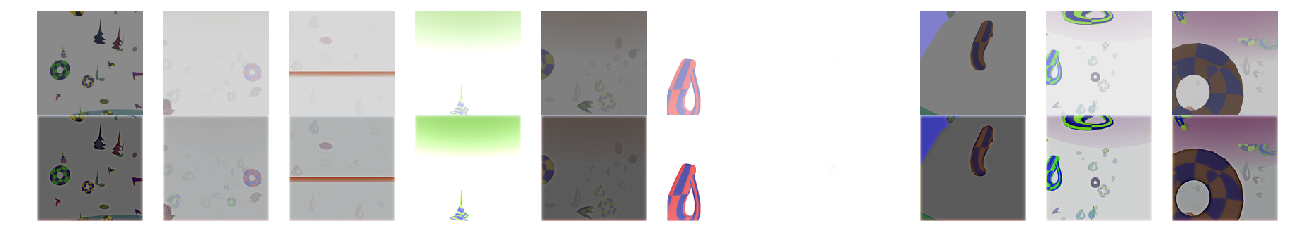

In [42]:
from torch.utils.data import DataLoader

haveCuda = torch.cuda.is_available()

path = './DehazeImages'
seed = 1

torch.manual_seed(seed)
if haveCuda:
  torch.cuda.manual_seed(seed)

tt = ToTensor()
trainingDS = DehazeDataset(path=path, type='training', percentage=0.8, transform=tt)
validationDS = DehazeDataset(path=path, type='validation', transform=tt)

trainingDL = DataLoader(trainingDS, batch_size=16, shuffle=True, num_workers=4)
validationDL = DataLoader(validationDS, batch_size=16, shuffle=True, num_workers=4)

nn = MyModelScript()

if haveCuda:
  nn = nn.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn.parameters(), lr=1e-4, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=53760, gamma=0.5)

numEpoch = 5

for i in range(numEpoch):

  train(i, nn, trainingDL, optimizer, criterion, haveCuda)
  eval(i, nn, validationDL, criterion, haveCuda)

nn.cpu()
nn.save('cuda_trined_model.pt')

print('Model saved')